In [22]:
import pandas as pd

df = pd.read_csv(
    "indeed.csv",
    sep=";",
    encoding="latin1"
)

df.head()



,Job,Country,State/Region,City,Impressions,Clicks,Apply starts,Applies,Cost per click (CPC),Cost per apply start (CPAS),Cost per apply (CPA),Clickthrough rate (CTR),Apply completion rate (ACR),Apply start rate (ASR),Apply rate (AR),Spend,Last updated,Created
0,(Junior) Werkvoorbereider,Netherlands,Zeeland,NaN,81,8,0,0,0,0,0,0.098765,0,0.000000,0,0,30-10-2025,30-9-2025
1,(Senior) Project Manager,Netherlands,Noord-Holland,Amsterdam,362,59,7,0,0.2016949152542373,1.7,0,0.162983,0,0.118644,0,11.9,22-5-2025,15-5-2025
2,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,543,51,1,0,0.22,11.22,0,0.093923,0,0.019608,0,11.22,22-5-2025,16-5-2025
3,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,291,26,0,0,0,0,0,0.089347,0,0.000000,0,0,22-5-2025,16-5-2025
4,Accountmanager,Netherlands,Utrecht (provincie),Amersfoort,223,29,2,0,0.27620689655172415,4.005,0,0.130045,0,0.068966,0,8.01,22-5-2025,16-5-2025


In [ ]:
#incorrect try #1

# 1. Imports
# =========================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv(
    "indeed.csv",
    sep=";",
    encoding="latin1"
)

# =========================
# 3. Initial exploration
# =========================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================
# 4. Rename columns (for simplicity, remove spaces and special characters)
# =========================
df = df.rename(columns=lambda x: x.strip().replace(" ", "_").replace("/", "_").replace("(", "").replace(")", ""))
print("\nRenamed columns:\n", df.columns)

# =========================
# 5. Drop duplicates
# =========================
df = df.drop_duplicates()
print(f"\nNumber of rows after removing duplicates: {df.shape[0]}")

# =========================
# 6. Handle missing target
# =========================
target = "Apply_start_rate_ASR"  # after renaming
df = df.dropna(subset=[target])

# =========================
# 7. Handle missing numerical features
# =========================
numerical_features = [
    "Impressions", "Clicks", "Apply_starts", "Applies",
    "Cost_per_click_CPC", "Cost_per_apply_start_CPAS",
    "Cost_per_apply_CPA", "Clickthrough_rate_CTR",
    "Apply_completion_rate_ACR", "Apply_rate_AR", "Spend"
]

# Fill missing numerical values with median (common strategy)
for col in numerical_features:
    df[col] = df[col].astype(str)  # ensure string first for cleaning
    df[col] = df[col].str.replace(".", "", regex=False)  # remove thousands separator
    df[col] = df[col].str.replace(",", ".", regex=False)  # convert decimal comma
    df[col] = pd.to_numeric(df[col], errors="coerce")  # convert to float
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# =========================
# 8. Handle missing categorical features
# =========================
categorical_features = ["Job", "Country", "State_Region", "City"]
for col in categorical_features:
    df[col] = df[col].astype(str).str.strip()  # remove extra spaces
    df[col] = df[col].fillna("Unknown")  # fill missing with placeholder

# =========================
# 9. Optional: Remove outliers (demonstration)
# =========================
# Here, remove rows where Impressions > 3 standard deviations
for col in ["Impressions", "Clicks", "Apply_starts"]:
    mean = df[col].mean()
    std = df[col].std()
    df = df[(df[col] >= mean - 3*std) & (df[col] <= mean + 3*std)]

# =========================
# 10. Feature and target separation
# =========================
X = df[categorical_features + numerical_features]
y = df[target]

# =========================
# 11. Train-test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 12. Preprocessing
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================
# 13. Random Forest model
# =========================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# =========================
# 14. Pipeline
# =========================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", rf_model)
    ]
)

# =========================
# 15. Train model
# =========================
model.fit(X_train, y_train)

# =========================
# 16. Predictions
# =========================
y_pred = model.predict(X_test)

# =========================
# 17. Evaluation (Train & Test)
# =========================
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Train metrics
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

# Test metrics
r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test Mean Squared Error (MSE): {mse_test:.4f}")


First 5 rows:
                          Job      Country         State/Region        City  \
0  (Junior) Werkvoorbereider  Netherlands              Zeeland         NaN   
1   (Senior) Project Manager  Netherlands        Noord-Holland   Amsterdam   
2             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
3             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
4             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   

   Impressions  Clicks  Apply starts  Applies Cost per click (CPC)  \
0           81       8             0        0                    0   
1          362      59             7        0   0.2016949152542373   
2          543      51             1        0                 0.22   
3          291      26             0        0                    0   
4          223      29             2        0  0.27620689655172415   

  Cost per apply start (CPAS)  Cost per apply (CPA)  Clickthrough rate (CTR)  \
0              

First 5 rows:
                          Job      Country         State/Region        City  \
0  (Junior) Werkvoorbereider  Netherlands              Zeeland         NaN   
1   (Senior) Project Manager  Netherlands        Noord-Holland   Amsterdam   
2             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
3             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   
4             Accountmanager  Netherlands  Utrecht (provincie)  Amersfoort   

   Impressions  Clicks  Apply starts  Applies Cost per click (CPC)  \
0           81       8             0        0                    0   
1          362      59             7        0   0.2016949152542373   
2          543      51             1        0                 0.22   
3          291      26             0        0                    0   
4          223      29             2        0  0.27620689655172415   

  Cost per apply start (CPAS)  Cost per apply (CPA)  Clickthrough rate (CTR)  \
0              

C:\Users\Ralvd\AppData\Local\Temp\ipykernel_6540\1098786740.py:43: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Created"] = pd.to_datetime(df["Created"], errors="coerce")



--- Model Evaluation ---
Train R² score: 0.0735
Train MSE: 0.023291
Test R² score: 0.0151
Test MSE: 0.024823

Top 15 Feature Importances:
                                  Feature  Importance
279                  Posting_week_of_year    0.077575
277                       Posting_weekday    0.073007
83                    Job_Proces Engineer    0.068947
63                Job_Mechanical engineer    0.062578
262                      City_Vlaardingen    0.060947
257                          City_Utrecht    0.054625
51               Job_Maintenance Engineer    0.054447
228                          City_Haarlem    0.053587
276                         Posting_month    0.049357
278                       Posting_quarter    0.031398
61                Job_Mechanical Engineer    0.027444
185  Job_Werkvoorbereider Energietechniek    0.025305
234                       City_Leeuwarden    0.024256
236                         City_Lelystad    0.024111
214                         City_Den Haag    0.0224

C:\Users\Ralvd\AppData\Local\Temp\ipykernel_6540\1098786740.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette="viridis")


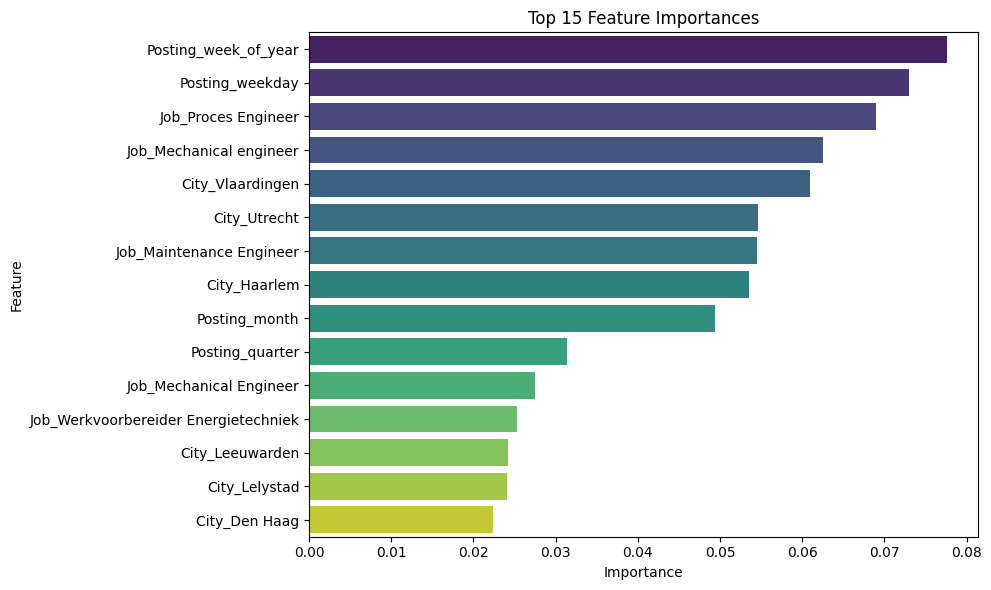

C:\Users\Ralvd\AppData\Local\Temp\ipykernel_6540\1098786740.py:160: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette="magma")


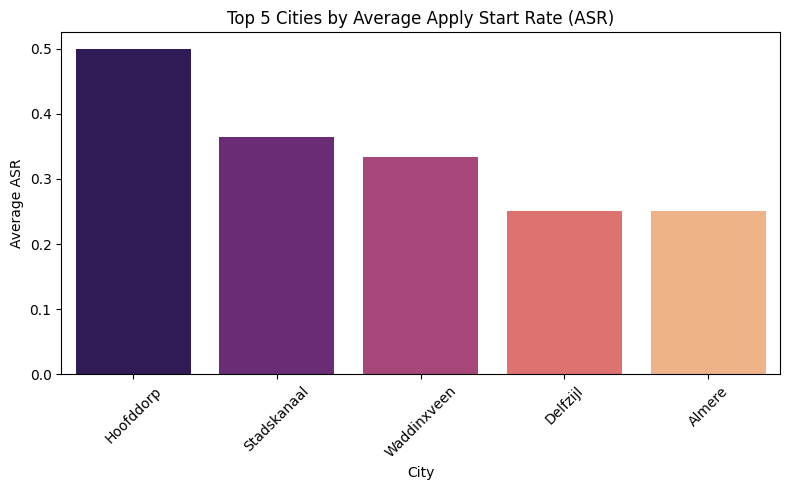

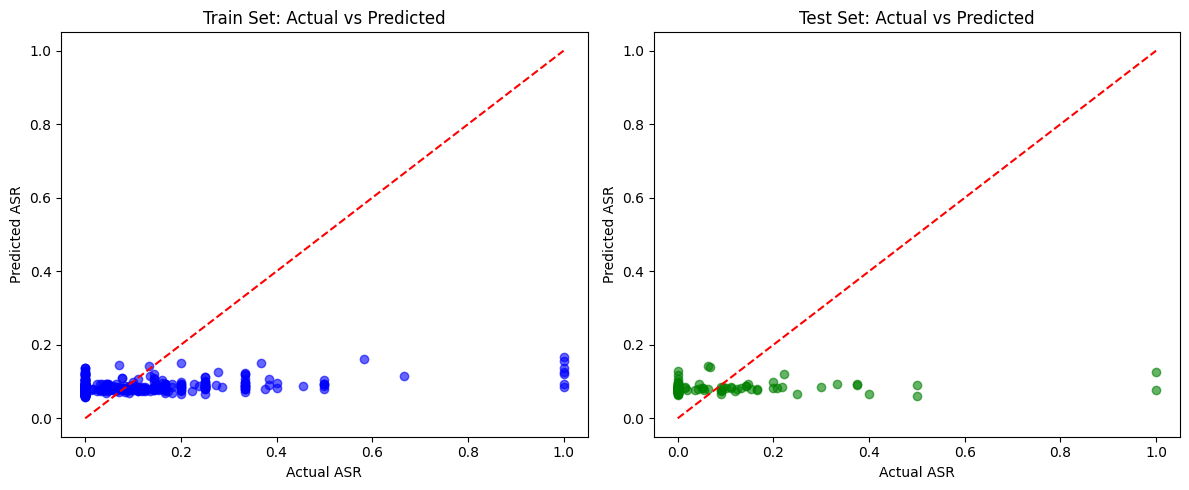

In [37]:
# =========================
# 1. Imports
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# =========================
# 2. Load dataset
# =========================
df = pd.read_csv("indeed.csv", sep=";", encoding="latin1")

# =========================
# 3. Initial exploration
# =========================
print("First 5 rows:\n", df.head())
print("\nColumns:\n", df.columns)
print("\nMissing values:\n", df.isnull().sum())

# =========================
# 4. Rename columns for convenience
# =========================
df = df.rename(columns=lambda x: x.strip().replace(" ", "_")
                                  .replace("/", "_")
                                  .replace("(", "")
                                  .replace(")", ""))

# =========================
# 5. Keep only realistic features
# =========================
categorical_features = ["Job", "City"]
target = "Apply_start_rate_ASR"

# Convert Created to datetime
df["Created"] = pd.to_datetime(df["Created"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["Created", target])

# =========================
# 6. Feature engineering from date
# =========================
df["Posting_month"] = df["Created"].dt.month
df["Posting_weekday"] = df["Created"].dt.weekday
df["Posting_quarter"] = df["Created"].dt.quarter
df["Posting_week_of_year"] = df["Created"].dt.isocalendar().week

numerical_features = ["Posting_month", "Posting_weekday", "Posting_quarter", "Posting_week_of_year"]

# =========================
# 7. Handle missing categorical values
# =========================
for col in categorical_features:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].fillna("Unknown")

# =========================
# 8. Train-test split
# =========================
X = df[categorical_features + numerical_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =========================
# 9. Preprocessing
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

# =========================
# 10. Random Forest model (tuned)
# =========================
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,           # limit depth
    max_features="sqrt",   # consider sqrt features per split
    min_samples_leaf=3,    # min samples per leaf
    random_state=42,
    n_jobs=-1
)

# =========================
# 11. Pipeline
# =========================
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", rf_model)
    ]
)

# =========================
# 12. Train model
# =========================
model.fit(X_train, y_train)

# =========================
# 13. Predictions
# =========================
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# =========================
# 14. Evaluation
# =========================
r2_train = r2_score(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)

r2_test = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("\n--- Model Evaluation ---")
print(f"Train R² score: {r2_train:.4f}")
print(f"Train MSE: {mse_train:.6f}")
print(f"Test R² score: {r2_test:.4f}")
print(f"Test MSE: {mse_test:.6f}")

# =========================
# 15. Feature importance
# =========================
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([cat_feature_names, numerical_features])

importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 15 Feature Importances:")
print(feature_importance_df.head(15))

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette="viridis")
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# =========================
# 16. Top 5 Cities by Average ASR
# =========================
top_cities = df.groupby("City")[target].mean().sort_values(ascending=False).head(5)
plt.figure(figsize=(8,5))
sns.barplot(x=top_cities.index, y=top_cities.values, palette="magma")
plt.title("Top 5 Cities by Average Apply Start Rate (ASR)")
plt.ylabel("Average ASR")
plt.xlabel("City")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =========================
# 17. Predicted vs Actual Plot (Train + Test)
# =========================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Train Set: Actual vs Predicted")

plt.subplot(1,2,2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual ASR")
plt.ylabel("Predicted ASR")
plt.title("Test Set: Actual vs Predicted")

plt.tight_layout()
plt.show()



Aggregated Feature Importance (3 main variables):
   Feature  Importance
0      Job    0.424595
1     City    0.398464
2  Created    0.176941


C:\Users\Ralvd\AppData\Local\Temp\ipykernel_6540\2266058196.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=agg_importance_df, palette="coolwarm")


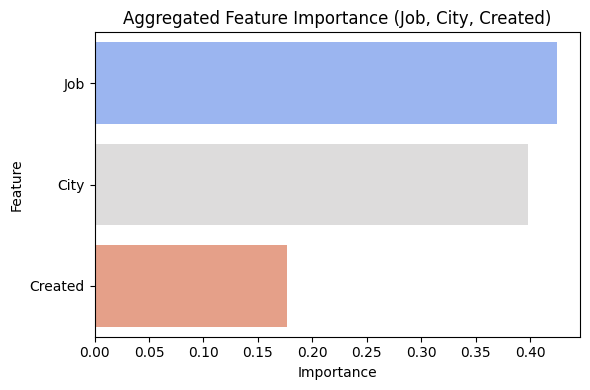

In [39]:
# =========================
# Aggregate importance by main variable
# =========================

# Identify dummy prefixes
job_cols = [f for f in all_feature_names_min if f.startswith("Job_")]
city_cols = [f for f in all_feature_names_min if f.startswith("City_")]
created_cols = ["Posting_month", "Posting_weekday", "Posting_quarter"]

# Sum importance per variable
job_importance = importances_min[[np.where(all_feature_names_min == f)[0][0] for f in job_cols]].sum()
city_importance = importances_min[[np.where(all_feature_names_min == f)[0][0] for f in city_cols]].sum()
created_importance = importances_min[[np.where(all_feature_names_min == f)[0][0] for f in created_cols]].sum()

agg_importance_df = pd.DataFrame({
    "Feature": ["Job", "City", "Created"],
    "Importance": [job_importance, city_importance, created_importance]
}).sort_values(by="Importance", ascending=False)

print("\nAggregated Feature Importance (3 main variables):")
print(agg_importance_df)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x="Importance", y="Feature", data=agg_importance_df, palette="coolwarm")
plt.title("Aggregated Feature Importance (Job, City, Created)")
plt.tight_layout()
plt.show()
